In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [10]:



REBUILD_DATA = True

class DogsVsCats():
    imageSize = 50
    cats = "CatsVsDogs/PetImages/Cat"
    dogs = "CatsVsDogs/PetImages/Dog"
    labels = {cats : 0, dogs : 1}
    trainingData = []
    catCount = 0
    dogCount = 0
    
    
    def makeTrainingData(self):
        for label in self.labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.imageSize, self.imageSize))
                    # np.eye(2).... will produce [0,1] or [1,0]
                    self.trainingData.append([np.array(img), np.eye(2)[self.labels[label]]])
                    # Here we are using hot vectors (like bitmask if second is one it's a dog)
                    if label == self.cats:
                        self.catCount += 1
                    elif label == self.dogs:
                        self.dogCount += 1
                except Exception as e:
                    #print(str(e))
                    pass # if some images are corrupted or not working
        np.random.shuffle(self.trainingData)
        np.save("trainingData.npy", self.trainingData)
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)
        
        
if REBUILD_DATA:
    dogsVsCats = DogsVsCats()
    dogsVsCats.makeTrainingData()

  0%|                                                                                        | 0/12501 [00:00<?, ?it/s]

CatsVsDogs/PetImages/Cat


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [01:13<00:00, 170.74it/s]


CatsVsDogs/PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:47<00:00, 261.59it/s]


Cats: 12476
Dogs: 12470


In [11]:
trainingData = np.load("trainingData.npy", allow_pickle = True)



In [12]:
print(len(trainingData))

24946


In [13]:
print(trainingData[0])

[array([[156, 156, 158, ...,  39,  29,  29],
       [156, 156, 158, ...,  35,  33,  35],
       [152, 158, 159, ...,  34,  30,  64],
       ...,
       [ 78,  74,  76, ...,  81,  84,  80],
       [ 78,  74,  79, ...,  82,  87,  86],
       [ 79,  79,  65, ...,  86,  81,  86]], dtype=uint8)
 array([1., 0.])]


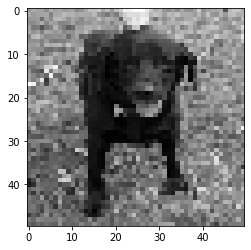

In [14]:
import matplotlib.pyplot as plt

plt.imshow(trainingData[1][0], cmap="gray")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Kernel/Window is 5
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x) # part of the forward
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))        
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

In [16]:
import torch.optim as optim

# moved to gpu (might get error here)
#optimizer = optim.Adam(net.parameters(), lr = 0.001)
#lossFunction = nn.MSELoss()

X = torch.Tensor([i[0] for i in trainingData]).view(-1, 50, 50)
X = X/255.0 # just scaling to make it between 0,1

Y = torch.Tensor([i[1] for i in trainingData])

valPercent = 0.1
valSize = int(len(X) * valPercent)
#print(valSize)

In [17]:
trainX = X[:-valSize]
trainY = Y[:-valSize]

testX = X[-valSize:]
testY = Y[-valSize:]

print(len(trainX))
print(len(testX))

22452
2494


In [24]:
batchSize = 100
epochs = 3
def train(net):
    for epoch in range(epochs):
        for i in tqdm(range(0, len(trainX), batchSize)):
            #print(i, i + batchSize)
            batchX = trainX[i:i+batchSize].view(-1,1,50,50)
            batchY = trainY[i:i+batchSize]

            net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
            outputs = net(batchX)
            loss = lossFunction(outputs, batchY)
            loss.backward()
            optimizer.step()
        
print(loss)

  0%|                                                                                          | 0/225 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [19]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        realClass = torch.argmax(testY[i])
        netOut = net(testX[i].view(-1,1,50,50))[0]
        predictedClass = torch.argmax(netOut)
        if predictedClass == realClass:
            correct += 1
        total += 1
print("Accurancy:", round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:09<00:00, 269.28it/s]

Accurancy: 0.656


In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [21]:
torch.cuda.device_count()

1

In [26]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [27]:
# Now we will repeat some things because we now run on the GPU
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    lossFunction = nn.MSELoss()
    for epoch in range(epochs):
        for i in tqdm(range(0, len(trainX), batchSize)):
            #print(i, i + batchSize)
            batchX = trainX[i:i+batchSize].view(-1,1,50,50)
            batchY = trainY[i:i+batchSize]
            
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
            outputs = net(batchX)
            loss = lossFunction(outputs, batchY)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}, Loss: {loss}")
            
train(net)

  1%|▋                                                                                 | 2/225 [00:00<00:17, 13.05it/s]

Epoch: 0, Loss: 0.24436016380786896


  1%|▋                                                                                 | 2/225 [00:00<00:17, 13.10it/s]

Epoch: 1, Loss: 0.2160254567861557


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.98it/s]


Epoch: 2, Loss: 0.17564542591571808
